# COMPUTER ASSIGNMENT 04

## U-net for image segmentation

In class, we talked about U-net for image segmentation. This assignment is intended to 
- help you better understand the concept of U-net for image segmentation 
- help you get started with designing networks in pytorch including loading data, network design, loss function, training and testing.

For this assignment, you will attempt to segment pedestrians, which is a challenge hosted on Kaggle. You could download from the [Kaggle](https://www.kaggle.com/jiweiliu/pennfudanped?select=readme.txt) Website.

You should create a folder 'data/' in the current folder and unzip the data into the folder.

Let's first take a look at the images in the training dataset
<img src="FudanPed00001.png" width="200" height="200" />
 
 Each image in the training dataset has a corresponding mask
<img src="FudanPed00001_mask.png" width="200" height="200" />


You should 
 -  Implement the U-net of the following architechture. Note that for the 2 consecutive Conv+BN+ReLU layers, the output channels of the first layer equals to the output channels of the second.
 ![U-net](UNET.png)
 -  Write function dice_coeff(input, target) for evaluation.
 -  Based on the definition of soft dice, write loss function SoftDICELoss().    
 -  Load training dataset and testing dataset.
Notice that you should rescale the images to a smaller size (for example 64x64/96x96/128x128). Otherwise it takes too long to train on cpu.
 -  Train your network for a few epochs, evaluate your network on validation dataset after each epoch.
 -  Test your network on testing dataset and report the DICE coefficient of it.
 -  Plot training loss and validation loss. Comment on the difference between them and when to stop training is appropriate based on your observation.
 -  Test your model by feeding in a new image in testing dataset. Plot your result of the original image, the mask and the segmented image.

In [1]:
import random
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
from tqdm import tqdm
import cv2

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms

from torch.utils.data import Dataset

In [3]:
# Use the GPU if you have one
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


### Let's first check what the data is look like!

In [4]:
img_list = sorted(glob.glob("./data/PNGImages/*.png"))
label_list = sorted(glob.glob("./data/PedMasks/*.png"))
assert len(img_list) == len(label_list)
print ("Collected {} images".format(len(img_list)))

Collected 170 images


Text(0.5, 1.0, 'Masked Image')

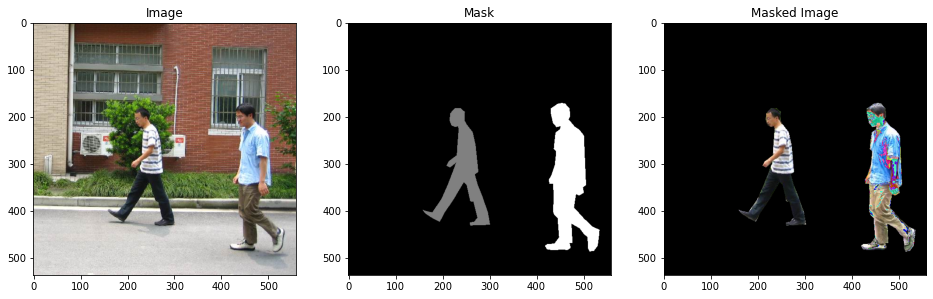

In [89]:
img = cv2.imread(img_list[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(label_list[0],cv2.IMREAD_GRAYSCALE)

plt.figure(figsize = (16,48))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(mask,cmap='gray')
plt.title('Mask')
plt.subplot(1,3,3)
plt.imshow((img*mask[:,:,None]))
plt.title('Masked Image')

### Looks a bit weird? This is because the mask is annotated with ID

Text(0.5, 1.0, 'Masked Image')

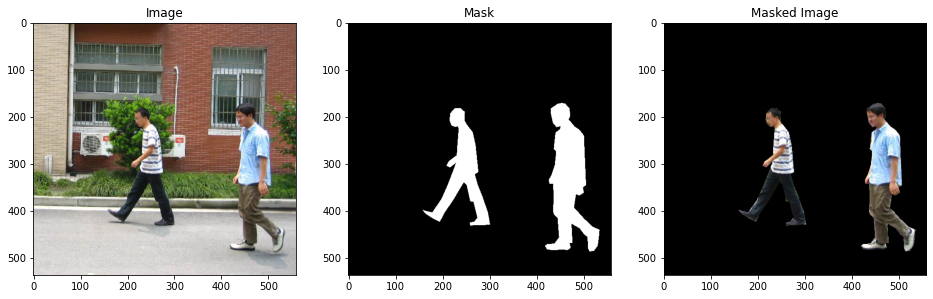

In [90]:
# different mask with different value -> indicate different ID
mask = mask>0

plt.figure(figsize = (16,48))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(mask,cmap='gray')
plt.title('Mask')
plt.subplot(1,3,3)
plt.imshow((img*mask[:,:,None]))
plt.title('Masked Image')

### [ TODO 1 ] First define following layer to be used later
- **Conv2d + BatchNorm2d + ReLu** as **single_conv layer** ,
- **down layer**: use **Maxpool2d** to downsample by a factor of 2
- **up layer**: takes two inputs of different dimensions. First use **nn.Upsample** to upsample the smaller input to be the same size as the larger, then concatenate the two along the channel dimension
-  **outconv layer**: **Conv2d** followed by **sigmoid activation** to generate probability for each pixel

You can check out the documentation in this link to understand how to use the methods called in the provided template:

 https://pytorch.org/docs/stable/nn.html


In [5]:
################################################ [TODO] ###################################################
# DEFINE SINGLE_CONV CLASS
class single_conv(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        # Define the layers here
        # Note: for conv, use a padding of (1,1) so that size is maintained
        self.conv = nn.Conv2d(in_ch,out_ch,padding=1,kernel_size=3)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)

        
    def forward(self, x):
        # define forward operation using the layers above
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

################################################ [TODO] ###################################################
# DEFINE DOWN CLASS
class down_layer(nn.Module):
    def __init__(self):
        super(down_layer, self).__init__()
        self.down = nn.MaxPool2d(kernel_size=(2,2),padding=0,dilation=1)
        
    def forward(self, x):
        x = self.down(x)
        return x

################################################ [TODO] ###################################################
# DEFINE UP CLASS
# Note that this layer will not only upsample x1, but also concatenate up-sampled x1 with x2 to generate the final output

class up_layer(nn.Module):
    def __init__(self):
        super(up_layer, self).__init__()       
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # use nn.Upsample() with mode bilinear
        
    # Note: after up, we also concatenate with previously saved feature x2
    def forward(self, x1, x2): # Takes in smaller x1 and larger x2
        # First we upsample x1 to be same size as x2
        x = self.up(x1)
        
        # Now we concatenat x2 and x1 along channel dimension
        # Note pytorch tensor shape correspond to: (batchsize, channel, x_dim, y_dim)
        x = torch.cat([x,x2],dim=1)
        
        return x

################################################ [TODO] ###################################################
# DEFINE OUTCONV CLASS
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch, out_ch,padding=1,kernel_size=3)

    def forward(self, x):
        # Forward conv layer + sigmoid
        x = self.conv(x)
        # x = F.sigmoid(x)
        x = torch.sigmoid(x)
        return x
    

In [6]:
################################################ [TODO] ###################################################
# Build your network with predefined classes: single_conv, down_layer, up_layer, outconv
# The number of input and output channels should follow the U-Net Structure shown above.
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels_in, n_channels_out):
        super(UNet, self).__init__()
        self.conv1 = single_conv(n_channels_in,16)
        self.conv2 = single_conv(16,16)
        self.down1 = down_layer()
        self.conv3 = single_conv(16,32)
        self.conv4 = single_conv(32,32)
        self.down2 = down_layer()
        self.conv5 = single_conv(32,32)
        self.conv6 = single_conv(32,32)
        self.up1 = up_layer()
        self.conv7 = single_conv(64,16)
        self.conv8 = single_conv(16,16)
        self.up2 = up_layer()
        self.conv9 = single_conv(32,16)
        self.conv10 = single_conv(16,16)
        self.out = outconv(16,n_channels_out)

    def forward(self, x):
        # Define forward pass
        ## Go down to lower dimension
        x1 = self.conv1.forward(x)
        x1 = self.conv2.forward(x1)
        skip1 = x1 # skip connection
        x2 = self.down1.forward(x1)
        x2 = self.conv3.forward(x2)
        x2 = self.conv4.forward(x2)
        skip2 = x2 # skip connection
        x3 = self.down2.forward(x2)
        x3 = self.conv5.forward(x3)
        x3 = self.conv6.forward(x3)
        
        ## Go up back to original dimension
        x = self.up1.forward(x3,skip2)
        x = self.conv7.forward(x)
        x = self.conv8.forward(x)
        x = self.up2.forward(x,skip1)
        x = self.conv9.forward(x)
        x = self.conv10.forward(x)
        x = self.out.forward(x)
        
        return x    

### [ TODO 2 ] Define evaluation function and loss function:
- **Evaluation function**  
    Dice coefficient is defined as $$DICE=\frac{2\times |A\cap B|}{|A| + |B|} = \frac{2\sum_i^N p_ig_i}{\sum_i^N p_i + \sum_i^N g_i}$$

    For the case of evaluating a Dice coefficient on predicted segmentation masks, we can approximate intersection of A and B as the element-wise multiplication between the prediction and target mask, and then sum the resulting matrix.

    In order to quantify the cardinality of A and B, we can use the simple sum of prediction and target mask.
- **Loss function**  
    Soft dice is defined as $$Soft DICE = \frac{2\sum_i^N p_ig_i}{\sum_i^N p_i^2 + \sum_i^N g_i^2}$$  
    
    Here, $p_i$ is the probability value of pixel $i$, not a binary value, which is different from the one in evaluation function. 
    For the denominator, some researchers use the simple sum whereas other researchers prefer to use the squared sum for this calculation. You can use either way.  
    
    Remember SoftDICE loss = 1 - SoftDICE = $1 - \frac{2\sum_i^N p_ig_i}{\sum_i^N p_i^2 + \sum_i^N g_i^2}$. 
    

**Note:remember to add a Laplace smooth to both the evaluation function and the loss function for better math stability, e.g. ${\mathrm{numerator + \epsilon}\over \mathrm{denominator + \epsilon}}$, where $\epsilon = 1$ typically, also you can try other values.**


In [7]:
################################################ [TODO] ###################################################
# define dice coefficient 
def dice_coeff(pred, target, smooth = 1):
    # smooth = 1
    
    # First let's flatten the matrix to [Batch Size, -1]
    # The flatten operation does not afftect the computation of the above equation
    num = pred.size(0) # sample num
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    # Then we compute the intersection and the sum of cardinality
    intersection = (m1*m2).sum(dim=1)
    cardinality = m1.sum(dim=1)+m2.sum(dim=1)
    # Followed by Dice
    dice = (2*intersection+smooth)/(cardinality+smooth)
    return dice.mean()


# define softdice
def softdice(pred, target, smooth = 1):
    # smooth = 1
    
    # First let's flatten the matrix to [Batch Size, -1]
    # The flatten operation does not afftect the computation of the above equation
    num = pred.size(0) # sample num
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    # Then we compute the intersection and the sum of cardinality
    intersection = (m1*m2).sum(dim=1)
    cardinality = (m1**2).sum(dim=1)+(m2**2).sum(dim=1)
    # Followed by Dice
    dice = (2*intersection+smooth)/(cardinality+smooth)
    return dice.mean()

# define SoftDICE loss as 1 - SoftDICE
class SoftDICELoss(nn.Module):
    def __init__(self, smooth = 1):
        super(SoftDICELoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        loss = 1 - softdice(pred,target,self.smooth)
        return loss

### Now let's randomly split the dataset for training/validation/test
This part has been done for you. But please read through so that you learn the general processing steps.

In [8]:
from random import shuffle

def shuffle_two_lists(listA, listB):
    temp = list(zip(listA, listB)) 
    shuffle(temp)
    return zip(*temp)

train_split_ratio = 0.8
test_split_ratio = 0.1

num_samples = len(img_list)
train_size = int(num_samples*train_split_ratio)
test_size = int(num_samples*test_split_ratio)
val_size = num_samples-train_size-test_size

img_list_shuffled, label_list_shuffled = shuffle_two_lists(img_list, label_list)

train_img_list, train_label_list = img_list_shuffled[:train_size], label_list_shuffled[:train_size]
val_img_list, val_label_list = img_list_shuffled[train_size:train_size+val_size], label_list_shuffled[train_size:train_size+val_size]
test_img_list, test_label_list = img_list_shuffled[train_size+val_size:], label_list_shuffled[train_size+val_size:]

print ("Training set size: {}".format(len(train_img_list)))
print ("Validation set size: {}".format(len(val_img_list)))
print ("Test set size: {}".format(len(test_img_list)))

Training set size: 136
Validation set size: 17
Test set size: 17


### Now let's implement a custom PyTorch dataset!
The important function in a Dataset object includes:
* def \_\_len\_\_(self): get the length of the dataset
* def \_\_getitem\_\_(self,idx): get the image-label pair given the index

You should implement those functions and also add random augmentation functions into the \_\_getitem\_\_() so the data could be augmented on the fly

In [9]:
class PedDataset(Dataset):
    def __init__(self, img_path_list, label_path_list, 
                     res=(96,96), IF_TRAIN=False):
        self.img_path_list = img_path_list
        self.label_path_list = label_path_list
        self.res = res  # image size
        self.IF_TRAIN = IF_TRAIN
        self.scale_factor = 0.1
        
        self.img_list, self.mask_list = self.preprocess()
        
    def __len__(self):
        return len(self.img_list)

    def preprocess(self):
        # ----------------------------------------------------------------
        # In preprocess(), we 1) read the images, 2) process the masks
        #                     3) resize the images and masks jointly
        # ----------------------------------------------------------------
        img_list, mask_list = [], []
        for idx in tqdm(range(len(self.label_path_list))):
            img = cv2.imread(self.img_path_list[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # into RGB region
            mask = cv2.imread(self.label_path_list[idx], cv2.IMREAD_GRAYSCALE)
            mask[mask>=1] = 255
            
            img = cv2.resize(img, self.res) # resize to (96*96)
            mask = cv2.resize(mask, self.res)
            
            img_list.append(img)
            mask_list.append(mask)
        return img_list, mask_list
                    
    # use index to get item
    def __getitem__(self, idx):
        img = self.img_list[idx]
        mask = self.mask_list[idx]
        
        # Random Augmentation here
        if self.IF_TRAIN:
            # ----------------------------------------------------------------
            # Implement random scaling here, with 0.7 prob we rescale the img
            # ---------------------------------------------------------------
            if random.random()<0.7: # probability = 0.7
                scale = np.random.randn()*self.scale_factor+1
                new_res = (int(self.res[0]*scale), int(self.res[1]*scale)) # new image size
                img_candidate = cv2.resize(img, new_res) # img after augment
                mask_candidate = cv2.resize(mask, new_res)
                if scale >= 1:  # augment
                    x_begin = (new_res[0]-self.res[0])//2
                    y_begin = (new_res[1]-self.res[1])//2
                    img = img_candidate[x_begin:x_begin+self.res[0],y_begin:y_begin+self.res[1]]
                    mask = mask_candidate[x_begin:x_begin+self.res[0],y_begin:y_begin+self.res[1]]
                else: # shrink
                    img = np.zeros_like(img)   # zeros with original size
                    mask = np.zeros_like(mask)
                    x_begin = (self.res[0]-new_res[0])//2 
                    y_begin = (self.res[1]-new_res[1])//2
                    img[x_begin:x_begin+new_res[0],y_begin:y_begin+new_res[1]] = img_candidate
                    mask[x_begin:x_begin+new_res[0],y_begin:y_begin+new_res[1]] = mask_candidate
            # ------------------------------------------------------------
            # Implement random flip here, with 0.5 prob we flip the image
            # -----------------------------------------------------------
            if random.random()<0.5: # probabily = 0.5 to filp
                img = np.array(img[:,::-1,:]) # filp the width
                mask = np.array(mask[:,::-1]) # also filp the width of mask
        
        # -------------------------------------------------------------
        # Need to:
        #        convert img and mask from numpy array to torch tensor 
        #        switch the channel dimension to the first dimension
        #        normalize image and maskes
        # -------------------------------------------------------------
        img = torch.Tensor(img).permute(2,0,1) 
        label = torch.Tensor(mask).unsqueeze(0) # add a dim at index0
        
        return img/255., label/255.

### Let's check if the dataset is correct!

100%|██████████| 170/170 [00:01<00:00, 121.03it/s]


Text(0.5, 1.0, 'Masked Image')

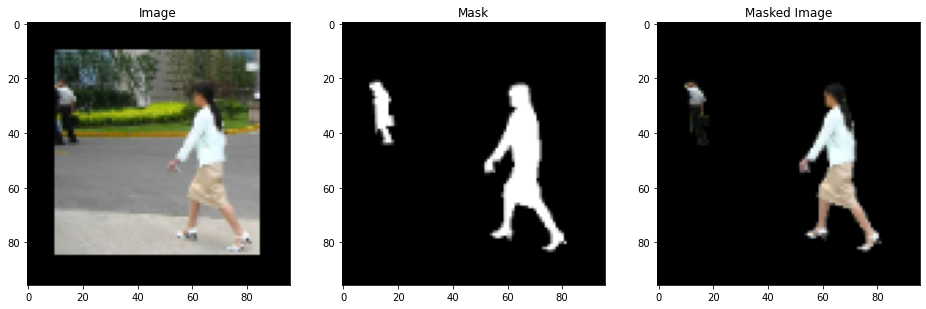

In [10]:
dataset = PedDataset(img_list, label_list, IF_TRAIN=True)
img, label = dataset[4]
img = img.permute(1,2,0)
label = label.permute(1,2,0)
plt.figure(figsize = (16,48))
plt.subplot(1,3,1)
plt.imshow(img.cpu().numpy())
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(label.squeeze(),cmap='gray')
plt.title('Mask')
plt.subplot(1,3,3)
plt.imshow((img*label).cpu().numpy())
plt.title('Masked Image')

### [ TODO 3 ] Start training your network

### Okay... It's time to generate the actual dataset!

In [13]:
# Use the predefined PedDataset to create train, val and test datasets
train_dataset = PedDataset(train_img_list, train_label_list,IF_TRAIN=True)
val_dataset = PedDataset(val_img_list, val_label_list)
test_dataset = PedDataset(test_img_list, test_label_list)

100%|██████████| 17/17 [00:00<00:00, 163.51it/s]


### Let's prepare some helper functions and define a few parameters for training and evaluation

**Note: since the dataset is quite small, the trained model may be prone to overfitting. Please be careful when setting hyper parameters, for example, it is recommended to choose a large batch size and to choose a relatively small number of epochs to stop training before overfitting occurs.**

In [14]:
################################################ [TODO] ###################################################
# Specify number of epochs, image scale factor, batch size and learning rate
NUM_EPOCH = 40 # e.g. 40
BATCH_SIZE = 8 # e.g. 8
LR = 0.001 # e.g. 0.001
SAVE_PATH = "./model/"

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)

In [100]:
################################################ [TODO] ###################################################
# Define the training process and return the average loss
def train_epoch(net, data_loader, optimizer, criterion, epoch):
    """
    Input:
    net: The UNet model you defined
    data_loader: a data loader object. Here you should use data loader constructed from training set
    optimizer: The optimizer, preferreablely ADAM
    criterion: The criterion to compute loss
    epoch: The number of current epoch 
    """
    # [TODO]: Set model in train mode   
    net.train() 
    net = net.to(device)

    loss_stat = []
    for i, img_mask in enumerate(data_loader):
        
        img, mask = img_mask
        # [TODO]: Send data to device
        img = img.to(device)
        mask = mask.to(device)
        # [TODO]: Feed data to model to get predictions
        outputs = net(img)
        # [TODO]: Compute loss and perform update of gradients
        optimizer.zero_grad()
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()
        
        loss_stat += [loss.item()]*img.shape[0]
    
    print ("Epoch {}: [{}/{}] Loss: {:.3f}".format(epoch+1, len(data_loader), len(data_loader),np.mean(loss_stat))) 
    
    return np.mean(loss_stat)

In [101]:
################################################ [TODO] ###################################################
# Define the training process and return the average loss
# Comparing to training, you don't need to compute gradients
def eval_epoch(net, data_loader, metric, criterion, epoch):
    # [TODO]: set model in eval mode to avoid updating BN layer
    net.eval()
    net = net.to(device)

    metric_stat = []
    val_loss_stat = []
    for i, img_mask in enumerate(data_loader):
        
        img, mask = img_mask
        # [TODO]: send data to device
        img = img.to(device)
        mask = mask.to(device)
        
        # [TODO]: feed data to the model. No need to compute grad.
        with torch.no_grad():
            pred = net(img)
            val_loss = criterion(pred, mask)
            
        # [TODO]: eval the results using DICE function as the metric
        # Convert probability to prediction mask
        pred = pred > 0.5
        err = metric(pred,mask)
        metric_stat += [err.item()]*img.shape[0]
        val_loss_stat += [val_loss.item()]*img.shape[0]
        
    print ("Dice: {:.3f}  Val Loss: {:.3f} ".format(np.mean(metric_stat), np.mean(val_loss_stat)))
    
    return np.mean(val_loss_stat), np.mean(metric_stat)

In [102]:
################################################ [TODO] ###################################################
# Create a UNET object. Input channels = 3, output channels = 1
net = UNet(3,1)
net.to(device)  # run net.to(device) if using GPU
print(net)

# If continuing from previously saved model, run
# net.load_state_dict(torch.load('PATH TO SAVED MODEL FILE'))

# This shows the number of parameters in the network
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

UNet(
  (conv1): single_conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv2): single_conv(
    (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (down1): down_layer(
    (down): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): single_conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv4): single_conv(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [103]:
################################################ [TODO] ###################################################
# Define an optimizer for your model.
# Pytorch has built-in package called optim. Most commonly used methods are already supported.
# Here we use ADAM as the optimizer
# For usage of ADAM, you can read https://www.programcreek.com/python/example/92667/torch.optim.Adam
# Also you can use SGD as the optimizer
# For usage of SGD, you can read https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html

optimizer = optim.Adam(net.parameters(), lr=LR)

# The loss function we use here is SoftDICE loss
# If your SoftDICE loss doesn't work, you can use nn.BCELoss()
# criterion = nn.BCELoss()
criterion = SoftDICELoss()

model_save_path = SAVE_PATH

################################################ [TODO] ###################################################
# Lists used for plotting loss
train_loss_list = []
val_loss_list = []
# Start training
for epoch in range(NUM_EPOCH):    
    loss = train_epoch(net, train_loader, optimizer, criterion, epoch)
    val_loss, dice = eval_epoch(net, val_loader, dice_coeff, criterion, epoch)
    
    # Record losses for each epoch
    train_loss_list.append(loss)
    val_loss_list.append(val_loss)
    
    # Save the model after each epoch
    if os.path.isdir(SAVE_PATH):
        torch.save(net.state_dict(),SAVE_PATH + 'PedSegEpoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),SAVE_PATH + 'PedSegEpoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved to {}'.format(epoch + 1, SAVE_PATH + 'PedSegEpoch{}.pth'.format(epoch + 1)))   

Epoch 1: [17/17] Loss: 0.508
Dice: 0.001  Val Loss: 0.626 
Checkpoint 1 saved to ./model/PedSegEpoch1.pth
Epoch 2: [17/17] Loss: 0.379
Dice: 0.179  Val Loss: 0.577 
Checkpoint 2 saved to ./model/PedSegEpoch2.pth
Epoch 3: [17/17] Loss: 0.337
Dice: 0.571  Val Loss: 0.356 
Checkpoint 3 saved to ./model/PedSegEpoch3.pth
Epoch 4: [17/17] Loss: 0.289
Dice: 0.537  Val Loss: 0.387 
Checkpoint 4 saved to ./model/PedSegEpoch4.pth
Epoch 5: [17/17] Loss: 0.280
Dice: 0.658  Val Loss: 0.295 
Checkpoint 5 saved to ./model/PedSegEpoch5.pth
Epoch 6: [17/17] Loss: 0.262
Dice: 0.640  Val Loss: 0.289 
Checkpoint 6 saved to ./model/PedSegEpoch6.pth
Epoch 7: [17/17] Loss: 0.249
Dice: 0.651  Val Loss: 0.284 
Checkpoint 7 saved to ./model/PedSegEpoch7.pth
Epoch 8: [17/17] Loss: 0.233
Dice: 0.613  Val Loss: 0.309 
Checkpoint 8 saved to ./model/PedSegEpoch8.pth
Epoch 9: [17/17] Loss: 0.241
Dice: 0.681  Val Loss: 0.270 
Checkpoint 9 saved to ./model/PedSegEpoch9.pth
Epoch 10: [17/17] Loss: 0.210
Dice: 0.699  Val

Text(0, 0.5, 'Soft DICE Loss')

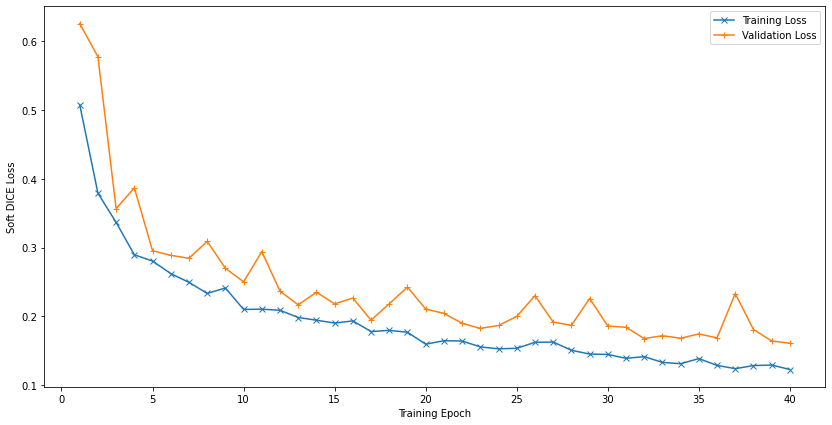

In [104]:
# Plot training loss and validation loss
plt.figure(figsize=(14,7))
epoch = np.arange(40)+1
plt.plot(epoch,train_loss_list,'x-',label="Training Loss")
plt.plot(epoch, val_loss_list,'+-',label="Validation Loss")
plt.legend()
plt.xlabel("Training Epoch")
plt.ylabel("Soft DICE Loss")

### DISCUSSION ABOUT RESULTS
- Discuss your observations on plots of training loss and validation loss and when to stop training is appropriate based on your observations.
- **Fill in your response in the cell below**

#### Discuss results here (modify this cell)

1. According to the results shown above, we can see that: the Training Loss basically keeps decreasing with the increase of training epoch.
2. The Validation Loss decreases consistently from epoch1 to epoch6, after that the Loss has some ups and downs.
3. The Validation Loss didn't keep decrease significantly. In epoch8 to epoch39, the Validation Loss has been fluctuating slightly in the range of 0.2 to 0.3. So I think stop training after epoch8 might also have good result.

### You should get a DICE score of at least 0.7

In [105]:
# Test on test dataset
test_loss, test_dice = eval_epoch(net, test_loader, dice_coeff, criterion, 1)


Dice: 0.796  Val Loss: 0.169 


In [130]:
checkpoint_path = './model/PedSegEpoch16.pth'
criterion = SoftDICELoss()
net = UNet(3,1)
net.load_state_dict(torch.load(checkpoint_path))
net.eval()
print("If we stop training after epoth8, we will have:")
test_loss, test_dice = eval_epoch(net, test_loader, dice_coeff, criterion, 1)

If we stop training after epoth8, we will have:
Dice: 0.712  Val Loss: 0.233 


### [Optional] If your model doesn't perform well, you can load a check point

In [16]:
checkpoint_path = './model/PedSegEpoch40.pth'
net = UNet(3,1)
net.load_state_dict(torch.load(checkpoint_path))
net.eval()

UNet(
  (conv1): single_conv(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv2): single_conv(
    (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (down1): down_layer(
    (down): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): single_conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv4): single_conv(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

### [ TODO 4 ] load one image from testing dataset and plot output mask

In [18]:
################################################ [TODO] ###################################################
# Define a function for prediction/testing
def predict_img(net, img, res, out_threshold=0.5):
    # set the mode of your network to evaluation
    net.eval()

    # convert from Height*Width*Channel TO Batch*Channel*Height*Width(Batch=1) and normalize to range (0,1)
    # resize image
    img = cv2.resize(img,res)
    # img = (img-np.min(img))/(np.max(img)-np.min(img))
    # img = img.astype('float32')
    img = torch.tensor(img)

    img = img.permute(2,0,1)
    img = img.unsqueeze(0)
    img = (img-img.min())/(img.max()-img.min())
    img = img.to(device)

    with torch.no_grad():
        ################################################ [TODO] ###################################################
        # predict the masks 
        pred = net(img)
        pred = pred.squeeze(0).squeeze(0)
        # threshold the probability to generate mask: mask=1 if prob > out_threshold, set mask to uint8 
        pred = pred > out_threshold
        pred = np.array(pred)
        pred = pred.astype('uint8')
    return pred

In [23]:
################################################ [TODO] ###################################################
# Load an image from testing dataset
idx = 6
img = cv2.imread(test_img_list[idx])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
label = cv2.imread(test_label_list[idx],cv2.IMREAD_GRAYSCALE)
ogSize = img.shape[1::-1]
################################################ [TODO] ###################################################

# Predict the mask
mask = predict_img(net=net,
                   img=img,
                   res=(128,128),
                   out_threshold=0.5)
# Rescale the mask back to original image size
mask = cv2.resize(mask,ogSize)

In [24]:
# Extract the pedestrian from the image using the predicted mask
img_seg = img*mask[:,:,None]

### Plot original image and mask image

Text(0.5, 1.0, 'Pedestrian')

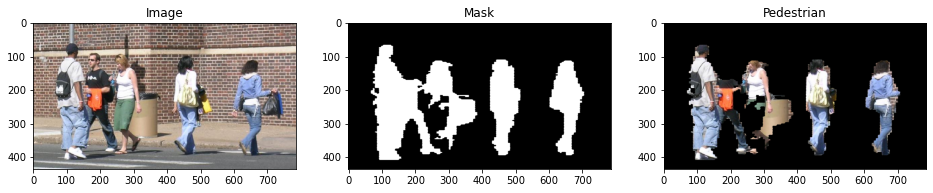

In [25]:
################################################ [TODO] ###################################################
# Plot original images and masks and segmented image
plt.figure(figsize = (16,48))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(mask,cmap='gray')
plt.title('Mask')
plt.subplot(1,3,3)
plt.imshow(img_seg)
plt.title('Pedestrian')

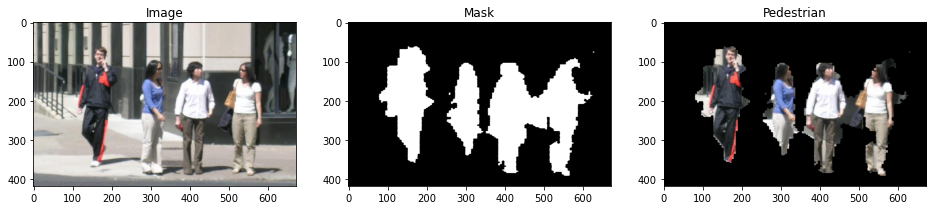

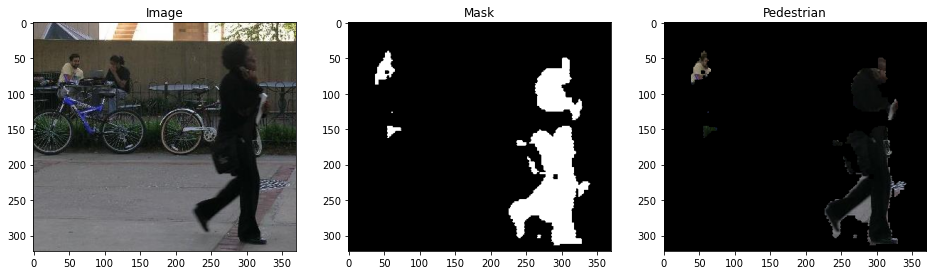

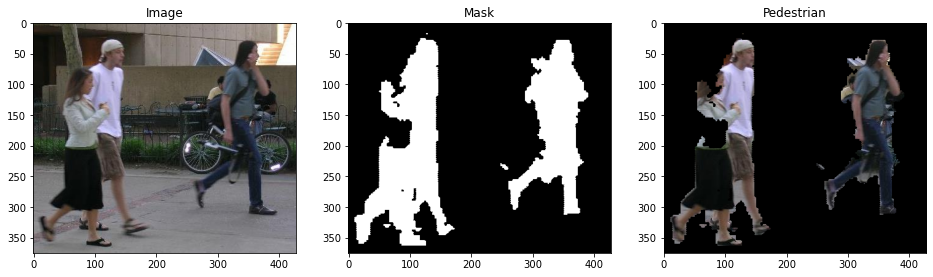

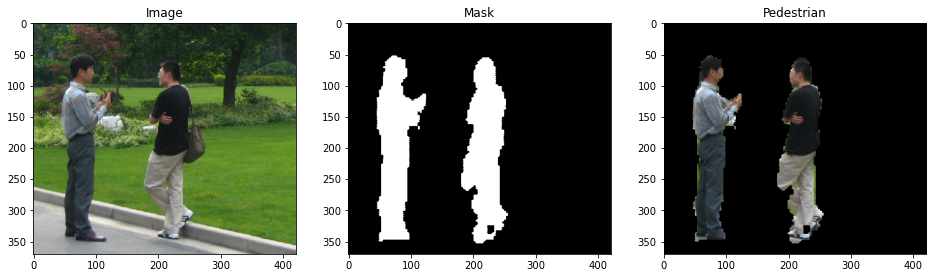

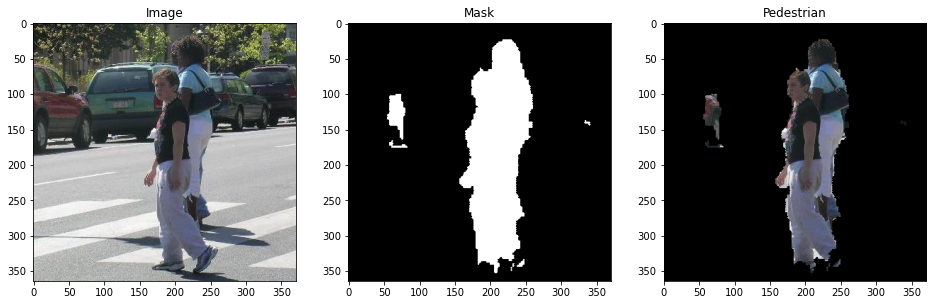

In [135]:
################################################ [TODO] ###################################################
# Display 5 more of test samples
for i in range(5):
    img = cv2.imread(test_img_list[idx+1+i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = cv2.imread(test_label_list[idx+1+i],cv2.IMREAD_GRAYSCALE)
    ogSize = img.shape[1::-1]

    mask = predict_img(net=net,
                   img=img,
                   res=(128,128),
                   out_threshold=0.3)
    
    mask = cv2.resize(mask,ogSize)
    img_seg = img*mask[:,:,None]
    plt.figure(figsize = (16,48))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(mask,cmap='gray')
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(img_seg)
    plt.title('Pedestrian')